<a href="https://colab.research.google.com/github/nekotanku/colab/blob/master/Udemy_pytorch_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#GPUの設定
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
#前処理
#ToTensor:画像をchannel Firstに変換、0~255 => 0~1.0のfloatに変換
transform = transforms.Compose([transforms.ToTensor()])
#Dataset用意
#root=>カレントディレクトリの下にdataディレクトリが作成されてそこにMNISTのdatasetがダウンロードされてくる
train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)

In [4]:
#ミニバッチ数設定
num_batches = 100

In [5]:
#dataloaderを作成
train_dataloader = DataLoader(train_dataset, batch_size=num_batches, shuffle=True)

In [6]:
#100個画像をとってきてみてみる
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()

In [7]:
#torch.Size([バッチサイズ, channel, H, W])
imgs.size()

torch.Size([100, 1, 28, 28])

In [8]:
#教師データ
labels

tensor([3, 5, 9, 4, 6, 7, 5, 9, 2, 6, 0, 5, 0, 1, 4, 3, 8, 8, 6, 4, 2, 2, 6, 1,
        0, 8, 8, 5, 1, 9, 0, 2, 7, 0, 8, 8, 4, 6, 4, 0, 9, 6, 8, 5, 6, 2, 7, 1,
        0, 4, 4, 5, 3, 3, 2, 6, 5, 6, 1, 6, 1, 1, 1, 1, 3, 4, 3, 5, 0, 2, 5, 3,
        2, 9, 9, 1, 4, 2, 7, 1, 9, 3, 3, 6, 5, 7, 0, 7, 3, 5, 9, 3, 7, 7, 4, 4,
        0, 1, 4, 1])

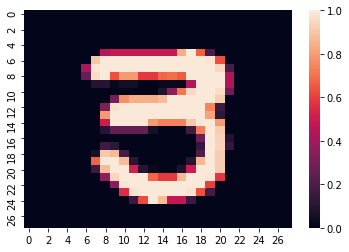

In [10]:
#画像を１つだけ持ってくる
img = imgs[0]
#配列を変更
img_permute = img.permute(1, 2, 0)
#heatmapで図示(tensorクラスから変更、二次元に変更)
sns.heatmap(img_permute[:,:,0])

In [11]:
labels[0]

tensor(3)

In [12]:
class MLP(nn.Module):
    #NNモデル構築
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28 * 28, 400),
            #inplace:メモリが少し節約できる
            nn.ReLU(inplace=True),
            nn.Linear(400, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 10)
        )
    #順伝播
    def forward(self, x):
        output = self.classifier(x)
        return output

In [15]:
#modelのインスタンス化
model = MLP()
#GPUを使う設定(モデルをGPUに送る)
model.to(device)

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=200, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
#学習
#損失関数
criterion = nn.CrossEntropyLoss()
#optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


#学習ループ
num_epochs = 15
losses = []
acc = []
for epoch in range(num_epochs):
    #lossとaccをためておくところを設定
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_dataloader:
        #1次元に変換
        imgs = imgs.view(num_batches, -1)
        #GPUに画像とラベルを送る
        imgs = imgs.to(device)
        labels = labels.to(device)
        #optimizerの初期化
        optimizer.zero_grad()
        #outputの計算
        output = model(imgs)
        #lossの計算
        loss = criterion(output, labels)
        #lossをrunning_lossに加える
        running_loss += loss.item()
        #精度の計算
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        #誤差逆伝播
        loss.backward()
        #重みの更新
        optimizer.step()
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    acc.append(running_acc)
    print("epoch:{}, loss: {}, acc: {}".format(epoch, running_loss, running_acc))

epoch:0, loss: 0.3374006025058528, acc: 0.9039673805236816
epoch:1, loss: 0.1293360298095892, acc: 0.9600166082382202
epoch:2, loss: 0.08540598858458301, acc: 0.9733991622924805
epoch:4, loss: 0.0480080445970331, acc: 0.9850653409957886
epoch:5, loss: 0.037838717141033464, acc: 0.9881487488746643
epoch:6, loss: 0.02886517921006695, acc: 0.9905150532722473
epoch:7, loss: 0.02742337913941204, acc: 0.9907650947570801
epoch:8, loss: 0.020716385885267908, acc: 0.9933648109436035
epoch:9, loss: 0.019052266220363285, acc: 0.9938149452209473
epoch:10, loss: 0.01768095098082995, acc: 0.9940982460975647
epoch:11, loss: 0.017140608706601293, acc: 0.9945650696754456
epoch:12, loss: 0.011183907684699079, acc: 0.996565580368042
epoch:13, loss: 0.01307751109500714, acc: 0.9956320524215698
epoch:14, loss: 0.013606156668878005, acc: 0.9958488345146179


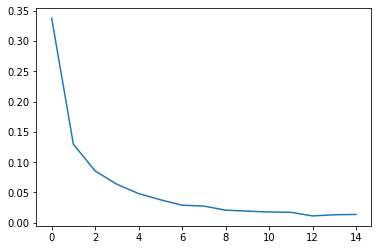

In [21]:
plt.plot(losses)

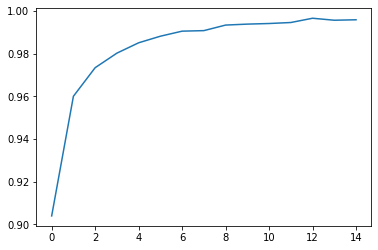

In [23]:
plt.plot(acc)

In [38]:
#試しに分類
train_iter = iter(train_dataloader)
imgs, labels = train_iter.next()

In [39]:
labels

tensor([0, 1, 5, 6, 0, 5, 4, 5, 0, 4, 9, 9, 4, 2, 6, 9, 6, 3, 0, 3, 7, 4, 3, 1,
        9, 4, 8, 0, 0, 2, 6, 9, 1, 5, 9, 9, 3, 9, 0, 1, 4, 8, 0, 1, 1, 6, 9, 9,
        7, 3, 8, 7, 8, 1, 1, 8, 4, 0, 1, 1, 6, 1, 3, 7, 2, 1, 3, 3, 0, 6, 2, 6,
        1, 9, 3, 2, 1, 6, 6, 4, 6, 2, 5, 2, 6, 1, 3, 1, 5, 5, 3, 1, 2, 6, 2, 3,
        2, 5, 2, 2])

In [40]:
imgs_gpu = imgs.view(100, -1).to(device)
output  = model(imgs_gpu)

In [41]:
pred = torch.argmax(output, dim=1)

In [42]:
pred

tensor([0, 1, 5, 6, 0, 5, 4, 5, 0, 4, 9, 9, 4, 2, 6, 9, 6, 3, 0, 3, 7, 4, 3, 1,
        9, 4, 8, 0, 0, 2, 6, 9, 1, 5, 9, 9, 3, 9, 0, 1, 4, 8, 0, 1, 1, 6, 9, 9,
        7, 3, 8, 7, 8, 1, 1, 8, 6, 0, 1, 1, 6, 1, 3, 7, 2, 1, 3, 3, 0, 6, 2, 6,
        1, 9, 3, 2, 1, 6, 6, 4, 6, 2, 5, 2, 6, 1, 3, 1, 5, 5, 3, 1, 2, 6, 2, 3,
        2, 5, 2, 2], device='cuda:0')

In [43]:
#パラメータを抜き出す
params = model.state_dict()

In [44]:
#modelの保存
torch.save(params, "model.prm")

In [45]:
#ファイルができたか確認
!ls

data  model.prm  sample_data


In [46]:
#パラメータファイルのロード
param_load = torch.load("model.prm")

In [47]:
#モデルのロード
model.load_state_dict(param_load)

<All keys matched successfully>